<h2> ======================================================</h2>
 <h1>MA477 - Theory and Applications of Data Science</h1> 
  <h1>Lesson 19: Ensemble Models </h1> 
 
 <h4>Dr. Valmir Bucaj</h4>
 United States Military Academy, West Point 
AY20-2
<h2>======================================================</h2>

<h2> Lecture Outline</h2>

<ul>
    <li>Voting Classifiers</li>
    <li>Python Implementation of VC</li>
    <li>Bagging</li>
    <li>Boosting: AdaBoost</li>

    
 </ul>
 
<h2>Voting Classifiers</h2>

<h3> Motivation</h3>

Suppose you ask a one of the best world experts on infectious disease a question regarding the COVID-19, and you will probably get a good anwer. However, suppose that you asked the same question to 1000 infectious disease doctors around the world, it is very likely that if you aggregate their answers and combine them in a single one, it will be better than the one provided by the first world expert. This phenomenon is often known as the <i>wisdom of the crowds</i>.

This is precisely the idea upon which the <b> voting classifier</b> and ensemble models in general, are based upon. 

Specifically, given a training set, we begin by individually training a few classifiers. For example, we may train a Logistic Regression Classifier, a KNN Classifier, a Random Forest Classifier, a Naive Bayes Classifier, SVM etc. Suppose that the best result that we get is 75% accuracy. We can create an even better model by aggregating their individual predictions into one model that predicts by majority vote; that is, it predicts tehe class that gets the most votes from these individual classifiers.


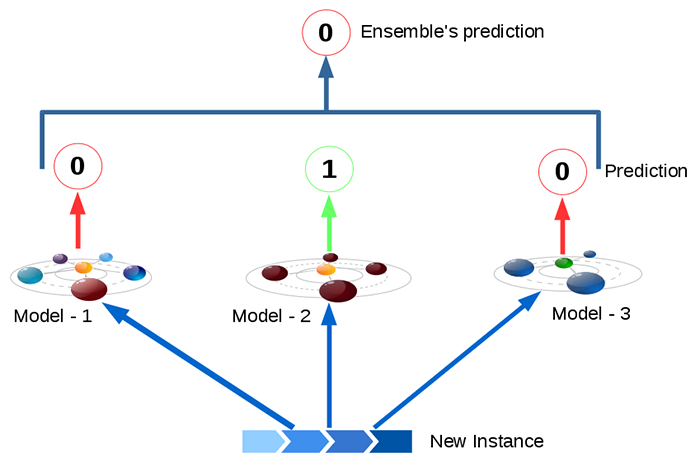

(Figure Source: https://www.datajango.com/heterogeneous-ensemble-learning-hard-voting-soft-voting/)


<h4>What is the justification behind such idea?</h4>

To understand why this idea works in practice let's imagine the following toy experiment.

Suppose we have a biased coin with a probability of 0.6 of coming up Heads and a probability of 0.4 of coming up Tails. Think of Heads as success. Now, if we run the experiment once, there is a 60% chance of success. Now, imagine we toss the coin 100 times. Then, what is the probability of getting a majority of heads?

This can be though of as a Bernoulli experiment. So, if we let $X$ denote this random variable then $X$ follows a Binomial distribution so the probability of getting exactly $k$ successes in $n$ independent trials is:

$$P(X=k)=C(n,k)p^k(1-p)^{n-k}$$ where $C(n,k)=\frac{n!}{(n-k)!k!}$ denote the binomial coefficient, and $p$ denotes the probability of success. 

So, to answer ouf question, the probability of getting at least 51 heads in 100 coin tosses would be:

$$P(X\geq 51)=\sum_{k=51}^{100}C(100,k)p^k(1-p)^{100-k}$$

We compute this below:

In [1211]:
from scipy.special import comb

In [1212]:
def coin_toss(n,k):
    sum=0
    for i in range(n//2):
        sum+=comb(n,k+i)*(.6)**(k+i)*(.4)**(n-k-i)
    return sum

In [1213]:
coin_toss(100,51)

0.972900802242991

In [ ]:
comb(100)

So, roughly $97\%$ of the time we can expect to have a majority of Heads in the 100 coin tosses. 

Analogously, suppose that we build an ensemble model that consists of 100 lower-level classifiers where each individual classifier has an accuracy of roughly $60\%$. Then, by aggregating the results with majority voting one can hope to get an accuracy level of up to $97\%$.

However, this is only true if all of the classifiers are independent from one another, which is never the case in practice since we ususally train these lower-level classifiers on overlapping training sets. The principle stands though; that is, while we may never experience these significant increases in performance by aggregating lower-level classifiers, often the results improve! 

<h3>Python Implementation</h3>

We will use the airine satisfaction data to build a voting classifier. For computational purposes, we will randomly select a subset of 10000 samples only.

In [184]:
import numpy as np
import pandas as pd

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

In [295]:
airline=pd.read_csv('airline_train.csv',index_col=[0])

In [296]:
airline.head()

,Unnamed: 0.1,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5.0,4,3,4.0,4,5,5,25.0,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1.0,1,5,3.0,1,4,1,1.0,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5.0,4,3,4.0,4,4,5,0.0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2.0,2,5,3.0,1,4,2,11.0,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3.0,3,4,4.0,3,3,3,0.0,0.0,satisfied


In [297]:
airline.shape

(103904, 25)

In [298]:
airline.drop(airline.columns[:2],inplace=True,axis=1)

In [299]:
airline.dropna(inplace=True)

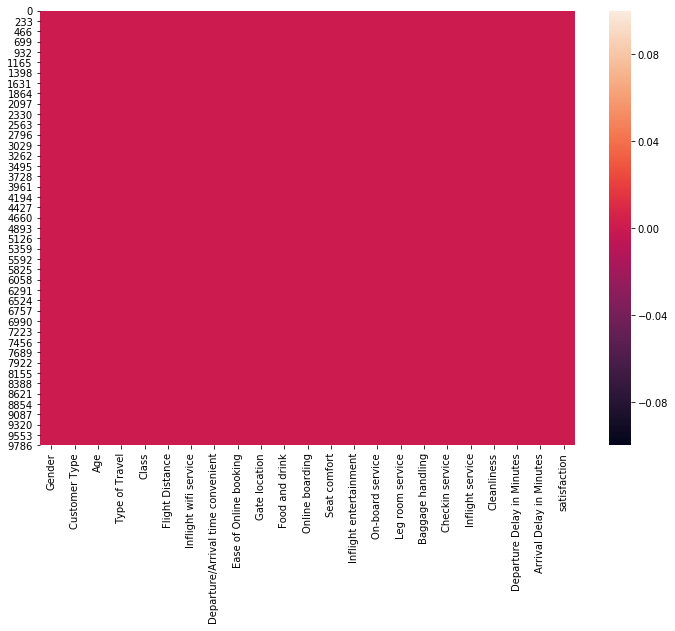

In [319]:
plt.figure(figsize=(12,8))
sns.heatmap(airline.isnull()==True, )

In [302]:
airline.reset_index(inplace=True,drop=True)

Next, we will randomly select 10000 rows.

In [303]:
import random

In [312]:
rows=random.sample(list(airline.index),10000)

In [313]:
len(set(rows))

10000

In [314]:
airline=airline.loc[rows]

In [315]:
airline.shape

(10000, 23)

In [316]:
airline.reset_index(inplace=True,drop=True)

In [317]:
airline.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,48,Business travel,Business,621,5,5,5,5,...,5.0,5,5,5.0,5,5,4,12.0,1.0,satisfied
1,Male,disloyal Customer,38,Business travel,Business,240,2,2,2,2,...,5.0,5,2,5.0,3,4,5,0.0,0.0,neutral or dissatisfied
2,Female,Loyal Customer,21,Personal Travel,Eco,326,5,5,5,3,...,4.0,4,5,2.0,3,2,4,0.0,0.0,satisfied
3,Female,Loyal Customer,39,Business travel,Business,391,3,3,3,3,...,4.0,4,4,4.0,3,4,4,0.0,0.0,satisfied
4,Male,Loyal Customer,38,Personal Travel,Eco,665,3,4,3,4,...,5.0,1,3,5.0,2,4,5,0.0,0.0,neutral or dissatisfied


In [318]:
airline['satisfaction']=airline['satisfaction'].apply(lambda x: 1 if x=='satisfied' else 0)

In [320]:
airline.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,48,Business travel,Business,621,5,5,5,5,...,5.0,5,5,5.0,5,5,4,12.0,1.0,1
1,Male,disloyal Customer,38,Business travel,Business,240,2,2,2,2,...,5.0,5,2,5.0,3,4,5,0.0,0.0,0
2,Female,Loyal Customer,21,Personal Travel,Eco,326,5,5,5,3,...,4.0,4,5,2.0,3,2,4,0.0,0.0,1
3,Female,Loyal Customer,39,Business travel,Business,391,3,3,3,3,...,4.0,4,4,4.0,3,4,4,0.0,0.0,1
4,Male,Loyal Customer,38,Personal Travel,Eco,665,3,4,3,4,...,5.0,1,3,5.0,2,4,5,0.0,0.0,0


Below we carry out the standard pre-processing steps:

In [332]:
X=airline.drop('satisfaction',axis=1)
y=airline['satisfaction']

In [333]:
X.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,Female,Loyal Customer,48,Business travel,Business,621,5,5,5,5,...,5,5.0,5,5,5.0,5,5,4,12.0,1.0
1,Male,disloyal Customer,38,Business travel,Business,240,2,2,2,2,...,5,5.0,5,2,5.0,3,4,5,0.0,0.0
2,Female,Loyal Customer,21,Personal Travel,Eco,326,5,5,5,3,...,4,4.0,4,5,2.0,3,2,4,0.0,0.0
3,Female,Loyal Customer,39,Business travel,Business,391,3,3,3,3,...,5,4.0,4,4,4.0,3,4,4,0.0,0.0
4,Male,Loyal Customer,38,Personal Travel,Eco,665,3,4,3,4,...,5,5.0,1,3,5.0,2,4,5,0.0,0.0


In [334]:
#Convert qualitative variables to numerical dummy variables

cols=['Gender','Customer Type', 'Type of Travel','Class']

X=pd.get_dummies(data=X,columns=cols,drop_first=True)

In [406]:
X.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,48,621,5,5,5,5,4,5,5,5.0,...,5,5,4,12.0,1.0,0,0,0,0,0
1,38,240,2,2,2,2,5,2,5,5.0,...,3,4,5,0.0,0.0,1,1,0,0,0
2,21,326,5,5,5,3,4,5,4,4.0,...,3,2,4,0.0,0.0,0,0,1,1,0
3,39,391,3,3,3,3,3,4,5,4.0,...,3,4,4,0.0,0.0,0,0,0,0,0
4,38,665,3,4,3,4,5,3,5,5.0,...,2,4,5,0.0,0.0,1,0,1,1,0


In [407]:
from sklearn.preprocessing import StandardScaler

In [408]:
scaler=StandardScaler()

In [409]:
scaled=scaler.fit_transform(X)

In [410]:
X_sc=pd.DataFrame(scaled,columns=X.columns)

In [445]:
X_sc.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,0.580095,-0.563998,1.697559,1.272492,1.588352,1.573013,0.579152,1.285160,1.182208,1.228360,...,1.338116,1.154930,0.537661,-0.070972,-0.373943,-0.988071,-0.469632,-0.672945,-0.898156,-0.281036
1,-0.081148,-0.944159,-0.545417,-0.694569,-0.542139,-0.768128,1.329543,-0.935227,1.182208,1.228360,...,-0.241341,0.305842,1.296961,-0.397741,-0.400536,1.012073,2.129327,-0.672945,-0.898156,-0.281036
2,-1.205260,-0.858348,1.697559,1.272492,1.588352,0.012252,0.579152,1.285160,0.422043,0.479634,...,-0.241341,-1.392335,0.537661,-0.397741,-0.400536,-0.988071,-0.469632,1.486006,1.113392,-0.281036
3,-0.015023,-0.793491,0.202242,-0.038882,0.168025,0.012252,-0.171239,0.545031,1.182208,0.479634,...,-0.241341,0.305842,0.537661,-0.397741,-0.400536,-0.988071,-0.469632,-0.672945,-0.898156,-0.281036
4,-0.081148,-0.520095,0.202242,0.616805,0.168025,0.792632,1.329543,-0.195098,1.182208,1.228360,...,-1.031070,0.305842,1.296961,-0.397741,-0.400536,1.012073,-0.469632,1.486006,1.113392,-0.281036


<h3> Validation Set</h3>

We will set aside a validation set.

In [446]:
from sklearn.model_selection import train_test_split

In [447]:
X_train,X_val,y_train,y_val=train_test_split(X_sc,y,test_size=0.2,random_state=11)

In what follows we will individually train and tune via cross-validation <b> Logistic Regression Classifier, KNN Classifier,</b> and <b> Random Forest Classifier</b> and then build an ensemble model using a <b> Voting Classifier</b> to see if we can improve upon the individual results.

<h3>Logistic Regression</h3>

In [476]:
from sklearn.model_selection import cross_validate, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from sklearn.metrics import accuracy_score

In [452]:
params={
    'penalty':['l1','l2'],
    'C':np.arange(0.01,2,0.01)
       }

rs_lg=RandomizedSearchCV(LogisticRegression(solver='liblinear'),param_distributions=params,n_iter=10,cv=10)

In [453]:
rs_lg.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_dist...
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1

In [454]:
rs_lg.best_score_

0.87525

In [455]:
rs_lg.best_params_

{'penalty': 'l1', 'C': 0.65}

In [465]:
penalties=['l1','l2']
param_c=np.arange(0.01,2,0.1)

kf=KFold(n_splits=10,shuffle=True,random_state=11)

results=defaultdict(dict)

for reg in penalties:
    reg_dict={}
    for c in param_c:
        
        lg_cv=cross_validate(LogisticRegression(penalty=reg,C=c,solver='liblinear'),X_train,y_train,cv=kf)
        reg_dict['param_'+str(c)]=lg_cv['test_score'].mean()
    results[reg]=reg_dict
        
        

In [466]:
df=pd.DataFrame(results)

In [467]:
df.index=param_c

In [468]:
df.head()

,l1,l2
0.01,0.872750,0.875000
0.11,0.874875,0.874500
0.21,0.875000,0.875000
0.31,0.875375,0.875125
0.41,0.875375,0.875250


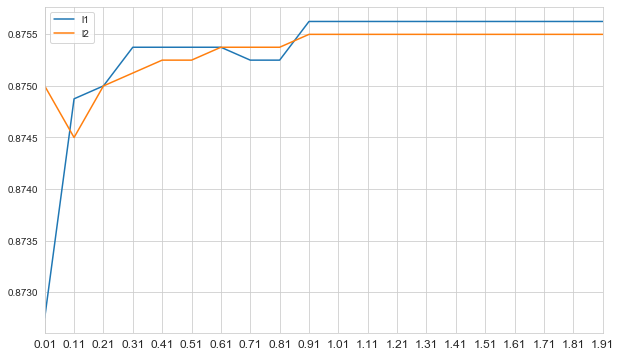

In [469]:
sns.set_style('whitegrid')

df.plot(figsize=(10,6))
plt.xticks(param_c,fontsize=12)
plt.show()

So, the best parameters seem to be penalty='l1' and C=1

In [470]:
lg=LogisticRegression(penalty='l1',C=1, solver='liblinear')

In [471]:
lg.fit(X_sc,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [475]:
pred_lg=lg.predict(X_val)

In [483]:
#Accuracy score on the validation set
accuracy_score(y_val,pred_lg)

0.8805

<h2>KNN Classifier</h2>

In [497]:
from sklearn.neighbors import KNeighborsClassifier

In [960]:

knn_res={}

for i in range(1,100,5):
    knn_cv=cross_validate(KNeighborsClassifier(n_neighbors=i),X_train,y_train,cv=kf)
    knn_res['K_'+str(i)]=knn_cv['test_score']

In [961]:
df_knn=pd.DataFrame(knn_res)

In [962]:
df_knn

,K_1,K_6,K_11,K_16,K_21,K_26,K_31,K_36,K_41,K_46,K_51,K_56,K_61,K_66,K_71,K_76,K_81,K_86,K_91,K_96
0,0.89875,0.89250,0.89125,0.88750,0.89750,0.89375,0.90000,0.89375,0.89000,0.89125,0.89000,0.88875,0.89000,0.88375,0.88875,0.88875,0.88625,0.88625,0.88875,0.88625
1,0.89625,0.90125,0.90250,0.89875,0.90125,0.89375,0.90000,0.89625,0.90000,0.89750,0.89500,0.89375,0.89125,0.89250,0.89250,0.88875,0.89000,0.88875,0.89250,0.88875
2,0.90500,0.90125,0.90625,0.90125,0.89625,0.89250,0.89500,0.89375,0.89125,0.88875,0.88750,0.88500,0.88625,0.88500,0.88625,0.89000,0.88375,0.88750,0.88500,0.88500
3,0.88500,0.90000,0.90250,0.89500,0.89875,0.89250,0.89125,0.88875,0.88500,0.88125,0.87750,0.87500,0.87625,0.87000,0.87250,0.87250,0.87125,0.87000,0.87125,0.87125
4,0.89000,0.90250,0.90750,0.90125,0.90250,0.89250,0.89375,0.89625,0.90125,0.90125,0.89875,0.89500,0.89500,0.89625,0.89375,0.89000,0.88875,0.88875,0.88750,0.88750
5,0.89750,0.91000,0.91500,0.91250,0.91750,0.91125,0.91625,0.91375,0.91250,0.91000,0.91375,0.91375,0.91500,0.91500,0.91375,0.91250,0.91250,0.91000,0.91375,0.91375
6,0.91250,0.92625,0.91250,0.91000,0.91000,0.91125,0.91250,0.90875,0.91125,0.90625,0.90875,0.90750,0.90875,0.90625,0.90750,0.90375,0.90250,0.90000,0.89875,0.90250
7,0.88250,0.89500,0.89375,0.88625,0.88625,0.88750,0.88750,0.88750,0.88500,0.88750,0.88250,0.87875,0.88250,0.88250,0.88250,0.88375,0.88875,0.88625,0.88625,0.88500
8,0.88875,0.91250,0.91875,0.91750,0.92000,0.92000,0.91750,0.91625,0.91625,0.91625,0.91625,0.91875,0.91250,0.91375,0.91750,0.91500,0.91250,0.91000,0.91375,0.90750
9,0.90125,0.91250,0.90500,0.90625,0.90250,0.90750,0.90750,0.90625,0.90875,0.91250,0.91250,0.91250,0.90875,0.90875,0.90500,0.90625,0.90250,0.90375,0.89875,0.89750


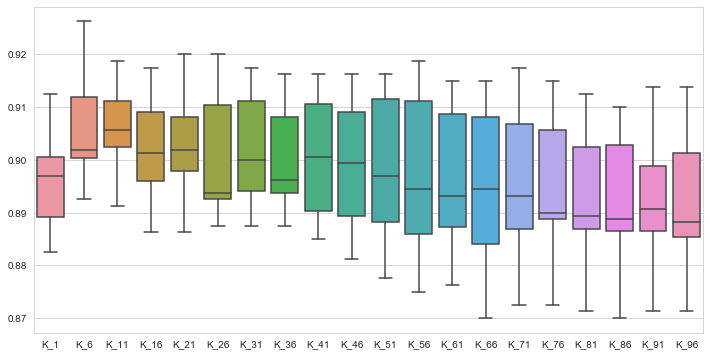

In [963]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_knn)
plt.show()

The best results are with K=11 neighbors: it has the heighest mean and lowest variance. Overall, KNN appears to perform better than Logistic Regression. Of course, there are other parmeters we can try to tune for, but for computational reasons we shall restrict ourselves to the number of neighbors only.

In [515]:
knn_11=KNeighborsClassifier(n_neighbors=11)

In [516]:
knn_11.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [517]:
knn_pred=knn_11.predict(X_val)

In [518]:
#Accuracy score on the validation set
accuracy_score(y_val,knn_pred)

0.914

<h2>Random Forest</h2>

In [519]:
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict

In [528]:
estimators=np.arange(1,150,15)
depths=np.arange(2,16,2)

# kf=KFold(n_splits=10,shuffle=True,random_state=42)

results=defaultdict(dict)

for depth in depths:
    depth_dict={}
    for est in estimators:
        rf_cv=cross_validate(RandomForestClassifier(n_estimators=est,max_depth=depth, max_features=5),X_train,y_train,
                            cv=kf)
        
        depth_dict['n_est_'+str(est)]=rf_cv['test_score']
    results['depth_'+str(depth)]=depth_dict
        
    

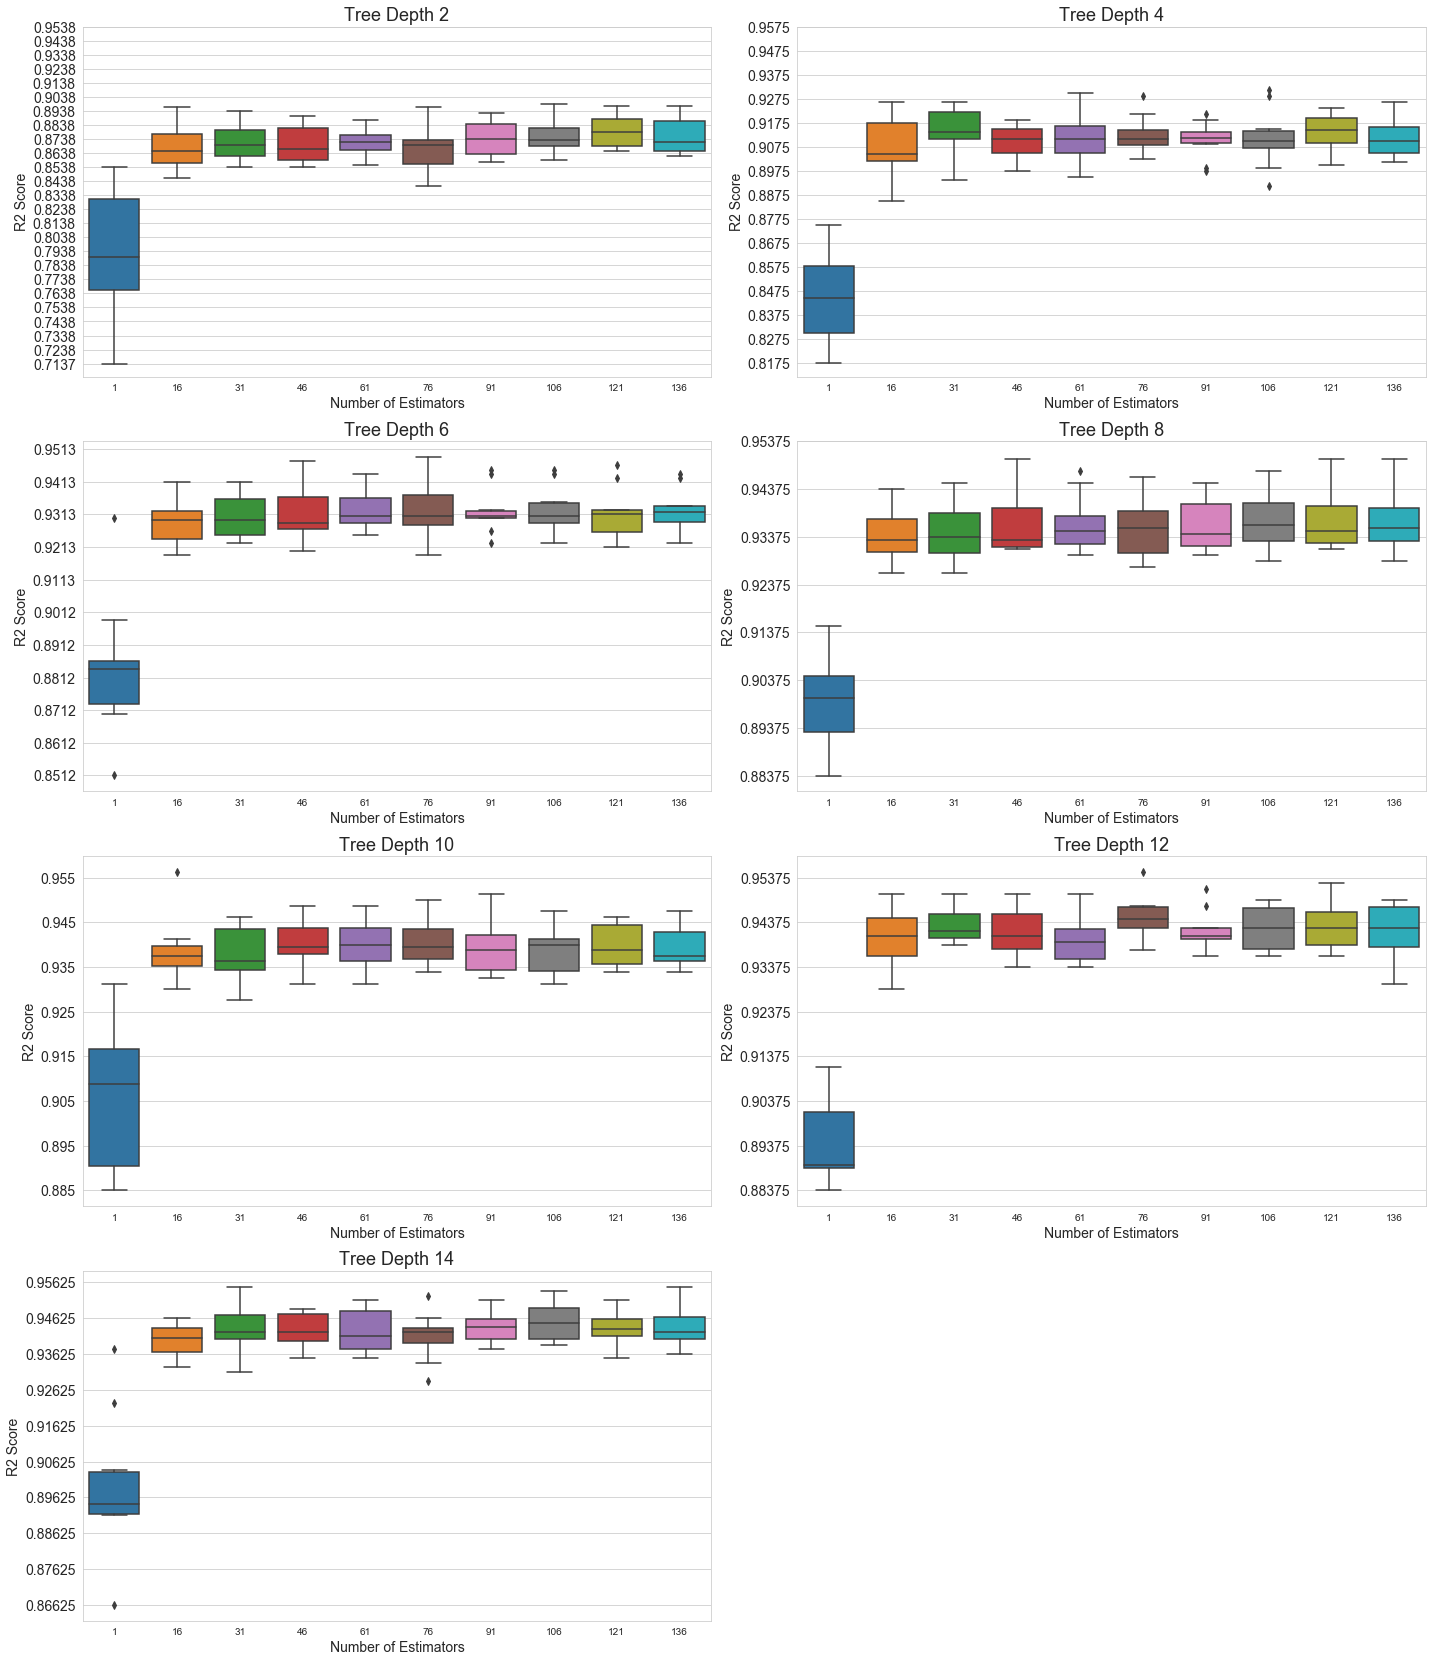

In [529]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,40))
m=len(results.keys())
n=len(results['depth_'+str(depth)].keys())
for i,depth in enumerate(depths,start=1):
    min_val=results['depth_'+str(depth)]['n_est_1'].min()
    plt.subplot(m,2,i)
    sns.boxplot(data=pd.DataFrame(results['depth_'+str(depth)]))
    plt.xticks(range(0,n),[x[6:] for x in results['depth_'+str(depth)].keys()])
    plt.yticks(np.arange(min_val,0.96,0.01),fontsize=14)
    plt.xlabel('Number of Estimators',fontsize=14)
    plt.ylabel("R2 Score",fontsize=14)
    plt.title("Tree Depth {}".format(depth),fontsize=18)
    
plt.tight_layout()

We see that a depth of 14 and 121 estimators seems to perform best: it has the highest mean and lowest variance

In [1220]:
rf=RandomForestClassifier(n_estimators=136,max_depth=14, max_features=5)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=136,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1221]:
rf_pred=rf.predict(X_val)

In [1222]:
accuracy_score(y_val,rf_pred)

0.9475

<h2> Saving Models</h2>

In [1223]:
from sklearn.externals import joblib

In [1225]:
joblib.dump(rf,'rf_model.pkl')
joblib.dump(knn_11, 'knn_model.pkl')
joblib.dump(lg, 'logreg_model.pkl')

['logreg_model.pkl']

In [1226]:
my_model=joblib.load('rf_model.pkl')

In [1227]:
pred=my_model.predict(X_val)

In [1228]:
accuracy_score(y_val,pred)

0.9475

<h2> Voting Classifier</h2>

In [786]:
from sklearn.ensemble import VotingClassifier

In [1229]:
#loading saved models

rf_model=RandomForestClassifier(n_estimators=121,max_depth=14, max_features=5)
#rf_model2=RandomForestClassifier(n_estimators=200,max_depth=16, max_features=6)
knn_model=KNeighborsClassifier(n_neighbors=11)
lg_model=LogisticRegression(penalty='l1',C=1,solver='liblinear')

In [1242]:
vcf=VotingClassifier(estimators=[('lg',lg_model),('knn',knn_model),('rf',rf_model)],voting='hard',
                    weights=[1,2,5])

In [1243]:
vcf_cv=cross_validate(vcf,X_train,y_train,cv=kf)

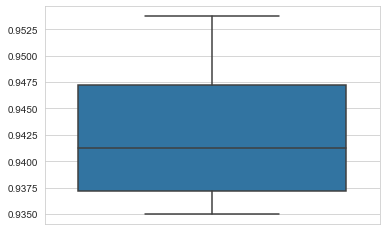

In [1244]:
sns.boxplot(vcf_cv['test_score'],orient='vert')

In [1245]:
vcf.fit(X_train,y_train)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=11,
                                                   p=2, weights='uniform')),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=14,
                                                     max_features=5,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrea

<h3>Predictions on Validation Set </h3>

In [1246]:
pred=vcf.predict(X_val)

In [1247]:
accuracy_score(y_val,pred)

0.9455

<h3>Saving Model</h3>

In [773]:
joblib.dump(vcf,'voting_classifier.pkl')

['voting_classifier.pkl']

<h2> Bagging Classifier</h2>

Bagging is very similar to Random Forests except that we may choose a different base learner other than a Decision Tree.

In [1116]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [1248]:
#bagging with Logistic Regressor as a base-learner

bag_lg=BaggingClassifier(LogisticRegression(solver='liblinear',C=1,penalty='l1'),
                         n_estimators=100,bootstrap=True)

bag_lg_cv=cross_validate(bag_lg,X_train,y_train,cv=kf)

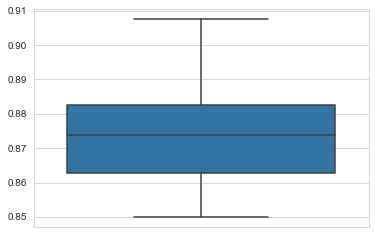

In [1249]:
sns.boxplot(bag_lg_cv['test_score'],orient='vert')

In [1250]:
bag_lg=BaggingClassifier(LogisticRegression(solver='liblinear',C=1,penalty='l1'),
                         n_estimators=200,max_samples=300,bootstrap=True)
bag_lg.fit(X_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='warn',
                                                    n_jobs=None, penalty='l1',
                                                    random_state=None,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=300, n_estimators=200, n_jobs=None,
                  oob_score=False, random_state=No

In [1251]:
bag_lg_pred=bag_lg.predict(X_val)

In [1252]:
accuracy_score(y_val,bag_lg_pred)

0.876

In [1253]:
#Bagging with Decision Tree as a base-learner
bag_tree=BaggingClassifier(DecisionTreeClassifier(),
                         n_estimators=200,bootstrap=True)

bag_tree_cv=cross_validate(bag_tree,X_train,y_train,cv=kf)

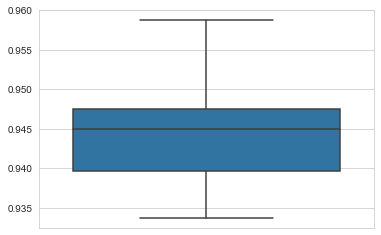

In [1254]:
sns.boxplot(bag_tree_cv['test_score'],orient='vert')

In [1255]:
bag_tree.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [1256]:
tree_pred=bag_tree.predict(X_val)

In [1257]:
accuracy_score(y_val,tree_pred)

0.9475

In [1196]:
#Bagging with KNN as a base-learner

bag_knn=BaggingClassifier(KNeighborsClassifier(n_neighbors=11),
                         n_estimators=50,bootstrap=True)

bag_knn_cv=cross_validate(bag_knn,X_train,y_train,cv=kf)

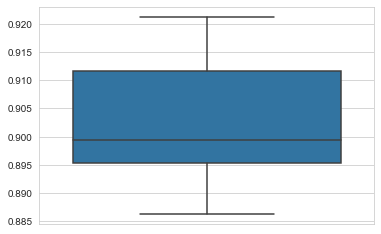

In [1197]:
sns.boxplot(bag_knn_cv['test_score'],orient='vert')

In [1208]:
bag_knn=BaggingClassifier(KNeighborsClassifier(n_neighbors=11),
                         n_estimators=200,max_samples=2000,bootstrap=True)
bag_knn.fit(X_train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                      leaf_size=30,
                                                      metric='minkowski',
                                                      metric_params=None,
                                                      n_jobs=None,
                                                      n_neighbors=11, p=2,
                                                      weights='uniform'),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=2000, n_estimators=500, n_jobs=None,
                  oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [1209]:
knn_bag_pred=bag_knn.predict(X_val)

In [1210]:
accuracy_score(y_val,knn_bag_pred)

0.9045